In [2]:
!splitcode --version
!kb --version
!fastq-dump --version

splitcode, version 0.30.0


usage: kb [-h] [--list] <CMD> ...

kb_python 0.29.3

positional arguments:
  <CMD>
    info      Display package and citation information
    compile   Compile `kallisto` and `bustools` binaries from source
    ref       Build a kallisto index and transcript-to-gene mapping
    count     Generate count matrices from a set of single-cell FASTQ files
    extract   Extract sequencing reads that were pseudoaligned to specific
              genes/transcripts (or extract all reads that were / were not
              pseudoaligned)

options:
  -h, --help  Show this help message and exit
  --list      Display list of supported single-cell technologies

fastq-dump : 3.0.3 ( 3.0.2 )



In [ ]:
outdir = "/mnt/data1/10XvParse/Analysis_3/"
fasta_folder = "FASTA/Processed/"
sra_folder = "SRA/"
tmp_folder = "tmp/"
file_names = []
srrs = []
sample_names = ['H1','H2']

with open("parse_extraction/10x_accession.txt") as access:
    for line in access:
        line = line.strip()
        if line.startswith('H'):
            name = f"10x_{line}"
        else:
            file_names.append(name)
            srrs.append(line)

In [5]:
for srr, name in zip(srrs, file_names):
    print(outdir+fasta_folder+name)
    !prefetch {srr} --max-size u -O {outdir+sra_folder}
    !fasterq-dump --outdir {outdir+fasta_folder} --temp {outdir+tmp_folder} \
        --outfile {name+".fastq"} --split-files --skip-technical \
        {outdir+sra_folder+srr+"/"+srr+".sra"} --threads 8
    !pigz {outdir+fasta_folder+name+"_1.fastq"} -p 8
    !pigz {outdir+fasta_folder+name+"_2.fastq"} -p 8

/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1_1

2025-08-07T03:14:42 prefetch.3.0.3: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2025-08-07T03:14:43 prefetch.3.0.3: 1) Downloading 'SRR26594154'...
2025-08-07T03:14:43 prefetch.3.0.3: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2025-08-07T03:14:43 prefetch.3.0.3:  Downloading via HTTPS...
2025-08-07T03:44:43 prefetch.3.0.3:  HTTPS download succeed
2025-08-07T03:44:43 prefetch.3.0.3:   verifying 'SRR26594154'...
2025-08-07T03:45:32 prefetch.3.0.3:  'SRR26594154' is valid
2025-08-07T03:45:32 prefetch.3.0.3: 1) 'SRR26594154' was downloaded successfully
2025-08-07T03:45:32 prefetch.3.0.3: 'SRR26594154' has 0 unresolved dependencies
spots read      : 203,134,663
reads read      : 406,269,326
reads written   : 406,269,326
/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H2_2

2025-08-07T04:29:11 prefetc

In [16]:
# Download human genome
!kb ref --overwrite -d human -i index.idx -g t2g.txt

[2025-08-07 14:11:04,583]    INFO [download] Downloading files for human (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/human_index_standard.tar.xz to tmp/human_index_standard.tar.xz
100%|████████████████████████████████████████| 138M/138M [00:03<00:00, 40.7MB/s]
[2025-08-07 14:11:08,147]    INFO [download] Extracting files from tmp/human_index_standard.tar.xz


In [ ]:
import multiprocessing

# Perform pseudoalignment of 10x reads
def align(name):
    read_in = outdir + fasta_folder + '10x_' + name
    read_out = outdir + '10x_' + name + '_out'
    !kb count --overwrite --h5ad -i index.idx -g t2g.txt -x 10XV3 -o {read_out} {read_in + "_1.fastq.gz"} {read_in + "_2.fastq.gz"}

with multiprocessing.Pool(processes=2) as pool:
    pool.map(align,sample_names)
    print("done")

[2025-08-13 14:15:07,390]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/10x_H1_out from
[2025-08-13 14:15:07,391]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1_1.fastq.gz
[2025-08-13 14:15:07,391]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H1_2.fastq.gz
[2025-08-13 14:15:07,405]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/10x_H2_out from
[2025-08-13 14:15:07,406]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H2_1.fastq.gz
[2025-08-13 14:15:07,406]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/10x_H2_2.fastq.gz
[2025-08-13 14:31:33,705]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/10x_H1_out/output.bus to /mnt/data1/10XvParse/Analysis_3/10x_H1_out/tmp/output.s.bus
[2025-08-13 14:32:05,051]    INFO [count] On-list not provided
[2025-08-13 14:32:05,051]    INFO [count] Copying

In [9]:
# Import packages
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from pybiomart import Server

# Preprocess

In [102]:
sample_datasets = []
for name in sample_names:
    data = anndata.read_h5ad(outdir+f"10x_{name}_out/counts_unfiltered/adata.h5ad")
    data.uns['name'] = name
    
    #read in gene names and replace as index
    data.var['gene_ids'] = data.var.index.tolist()

    gene_names = []
    with open(outdir+f"10x_{name}_out/counts_unfiltered/cells_x_genes.genes.names.txt", 'r') as file:
        for line in file:
            gene_names.append(line.strip())
    data.var_names = gene_names

    # set up metadata for genes and cells
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_genes=1)
    
    sample_datasets.append(data)
all_data = anndata.concat(sample_datasets, axis='obs', fill_value=0, join='outer', label='sample', merge='first', keys=sample_names, index_unique='-')
all_data.var['n_cells'] = sample_datasets[0].var['n_cells'].add(sample_datasets[1].var['n_cells'], fill_value=0)

# 10x Quality Control

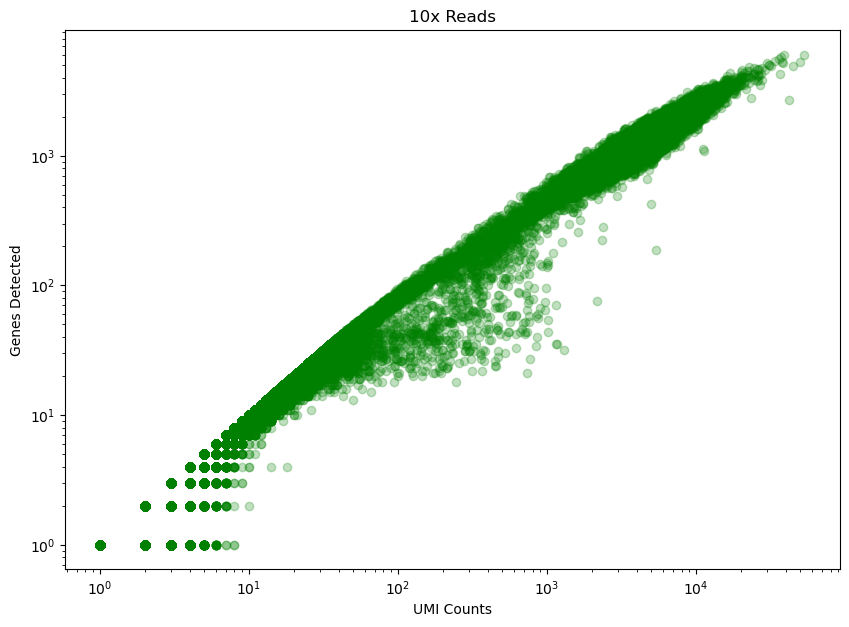

In [126]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(all_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(all_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("10x Reads")

plt.show()

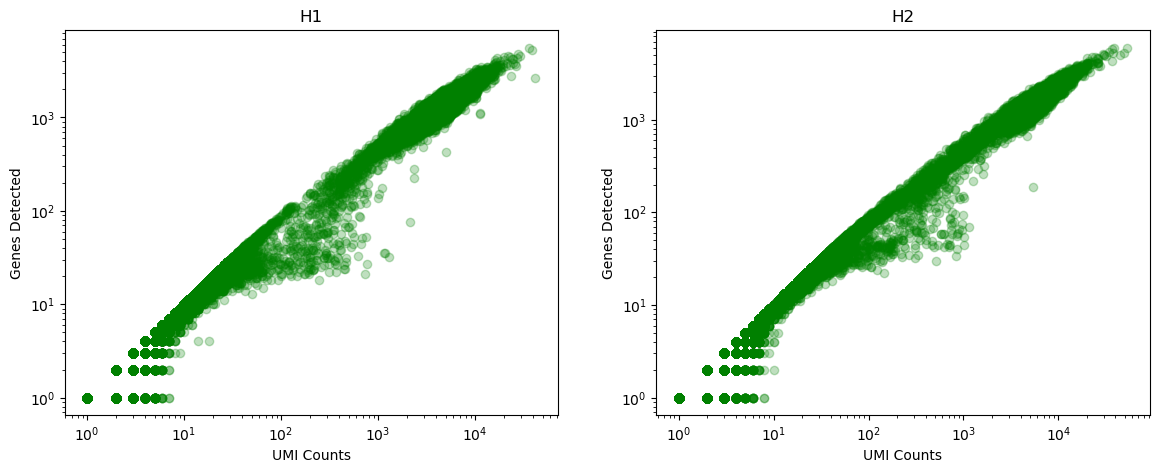

In [79]:
fig, axs = plt.subplots(1,2, figsize=(14, 5))

for ax, name in zip(axs, sample_names):
    X = all_data.X[(all_data.obs['sample'] == name).tolist(),:]
    x = np.asarray(X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(name)

plt.show()

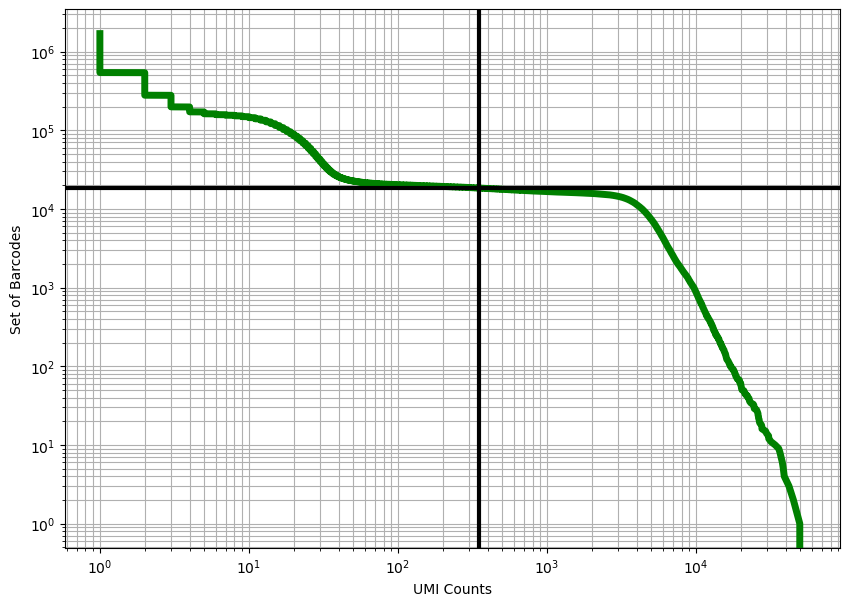

In [82]:
cutoff = 350  
knee = np.sort((np.array(all_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [83]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

18,398 cells passed the 350 UMI threshold


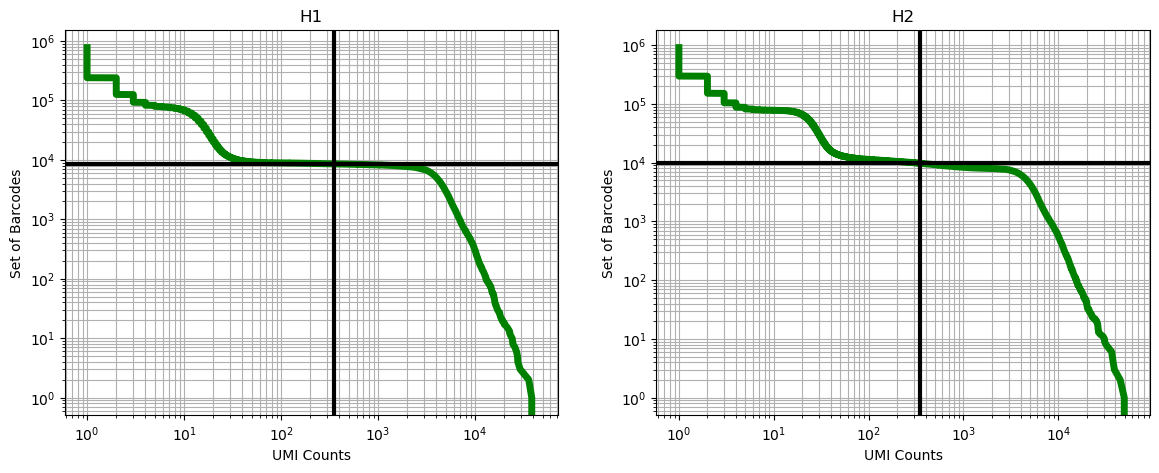

In [80]:
fig, axs = plt.subplots(1,2, figsize=(14, 5))

cutoffs = [350,350]
n_cells = []
for ax, cutoff, name in zip(axs,cutoffs,sample_names):    
    # Threshold cells according to knee plot 
    X = all_data.X[(all_data.obs['sample'] == name).tolist(),:]
    knee = np.sort((np.array(X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]
    n_cells.append(num_cells)

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")

    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Set of Barcodes")
    ax.set_title(name)
    ax.grid(True, which="both")
plt.show()

In [81]:
for num_cells, cutoff in zip(n_cells, cutoffs):
    print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

8,613 cells passed the 350 UMI threshold
9,784 cells passed the 350 UMI threshold


In [108]:
# Query Ensembl for lncRNA genes
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['hsapiens_gene_ensembl']

result = dataset.query(attributes=[
    'ensembl_gene_id_version', 'transcript_biotype'
], filters={'transcript_biotype': ['lncRNA']})

In [109]:
def addCellMetrics(data):
    # Identify lncRNA genes
    data.var["is_lnc"] = data.var["gene_ids"].isin(result["Gene stable ID version"])

    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    data.var["is_mito"] = data.var.index.str.startswith("MT")
    # ribosomal genes
    data.var["is_ribo"] = data.var.index.str.startswith(("RPS", "RPL"))

    mito_counts = data[:, data.var['is_mito']].X.sum(axis=1)
    ribo_counts = data[:, data.var['is_ribo']].X.sum(axis=1)
    nc_counts = data[:, data.var['is_lnc']].X.sum(axis=1)

    # Calculate total counts per cell
    total_counts = data.X.sum(axis=1)

    # Calculate percent mitochondrial and ribosomal gene expression per cell
    data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
    data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
    data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

    data.obs['n_counts'] = data.X.sum(axis=1).A1

In [110]:
addCellMetrics(all_data)

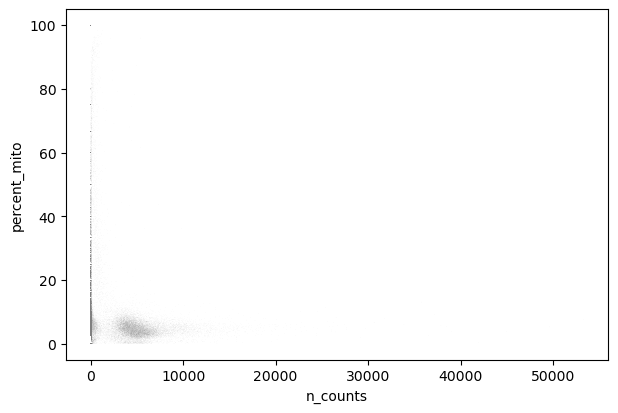

In [111]:
sc.pl.scatter(all_data, x='n_counts', y='percent_mito')

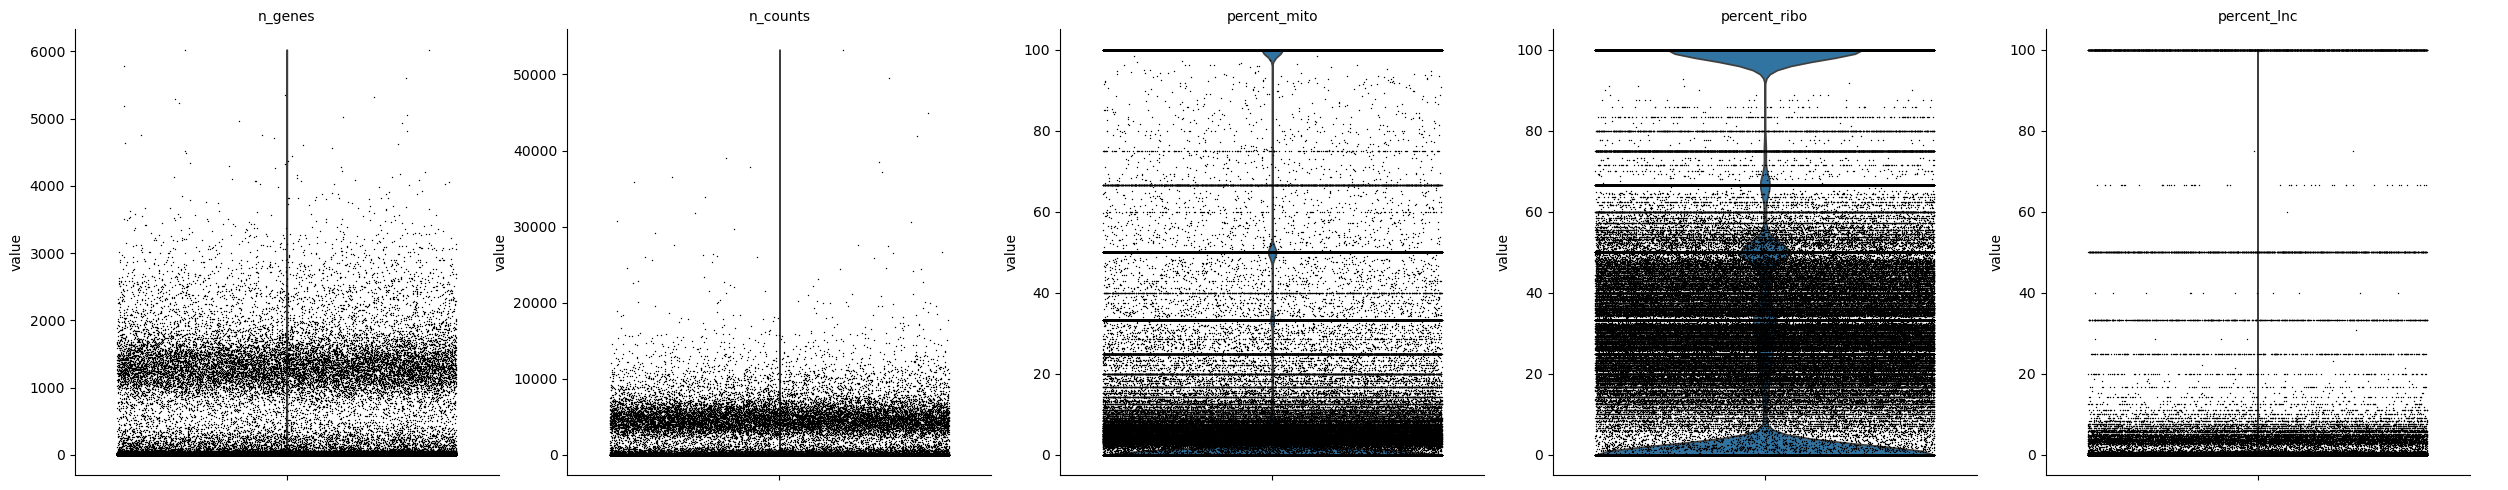

In [86]:
sc.pl.violin(all_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)


In [112]:
for data in sample_datasets:
    addCellMetrics(data)

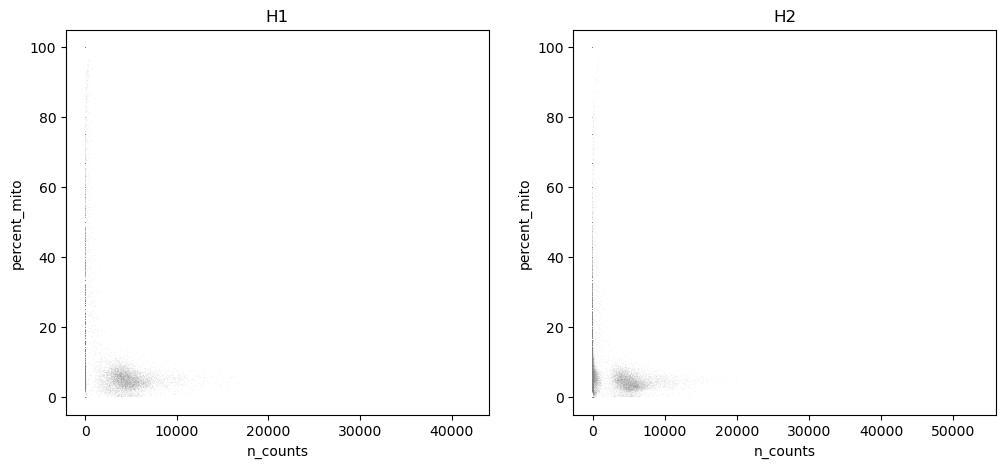

In [115]:
fig, axs = plt.subplots(1,2, figsize = (12,5))
for ax, data in zip(axs, sample_datasets):
    sc.pl.scatter(data, x='n_counts', y='percent_mito',ax=ax,show=False)
    ax.set_title(data.uns['name'])
plt.show()

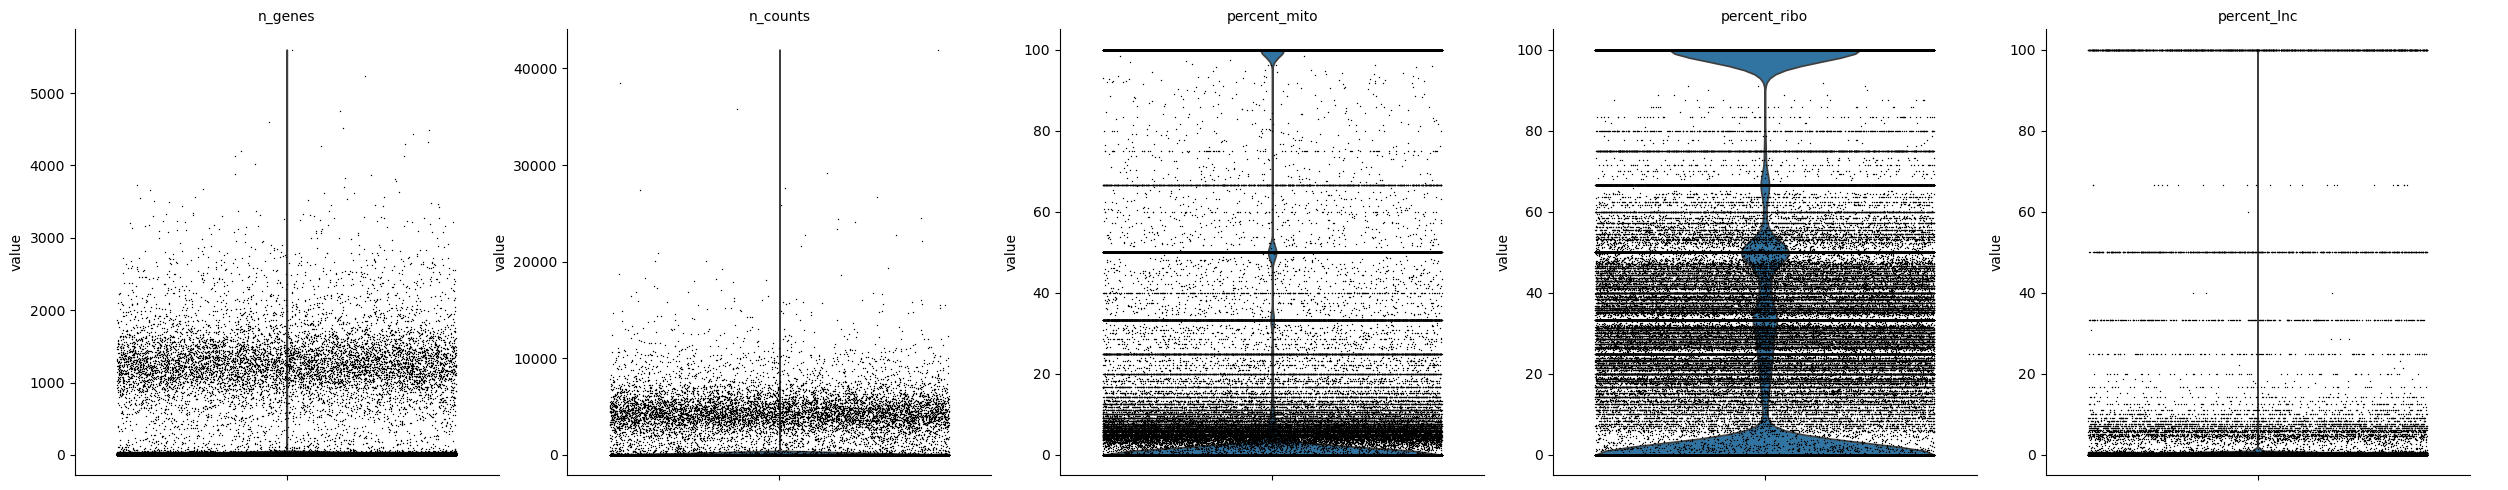

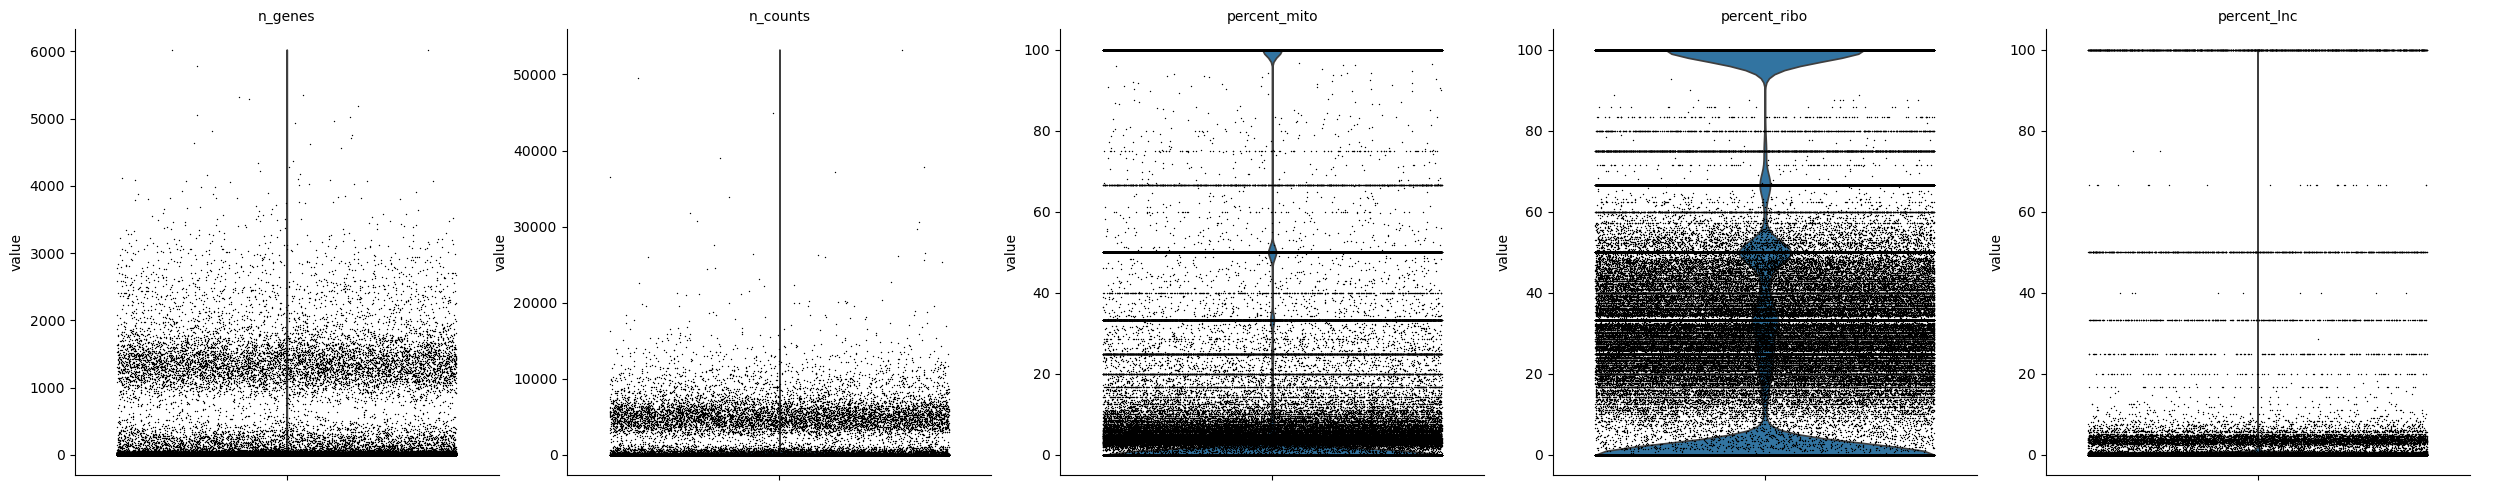

In [ ]:
for data in sample_datasets:
    sc.pl.violin(data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True, show=False)
plt.show()

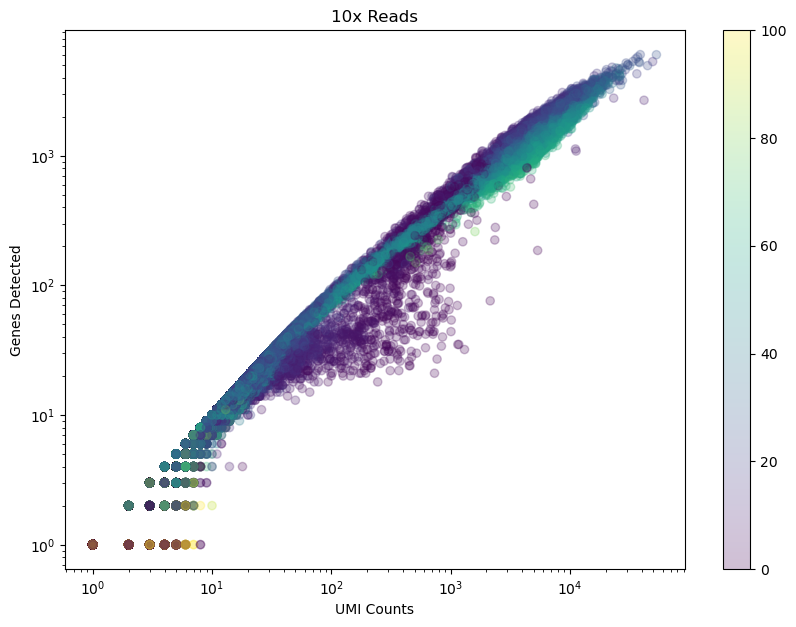

In [125]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(all_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(all_data.X>0, axis=1))[:,0]

lnc_content = all_data.obs['percent_ribo'].tolist()

im = ax.scatter(x, y, c=lnc_content, cmap = 'viridis', alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("10x Reads")
fig.colorbar(im, ax=ax)

plt.show()

# 10x Gene Counts

In [ ]:
# Find top 10 genes by number of cells expressed
top_genes = all_data.var.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(all_data[:,gene].X.toarray().transpose()[0] / np.array(all_data.obs['n_counts'].tolist()) * 100))

In [ ]:
# Get percent counts for each gene and add to metadata
data.var['percent_counts'] = data.X.sum(axis=0).A1  / data.X.sum() * 100

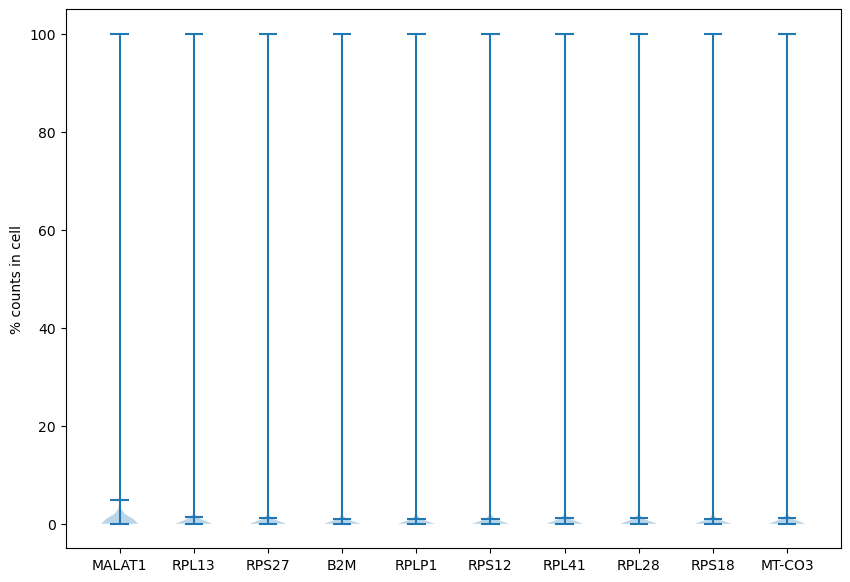

In [ ]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

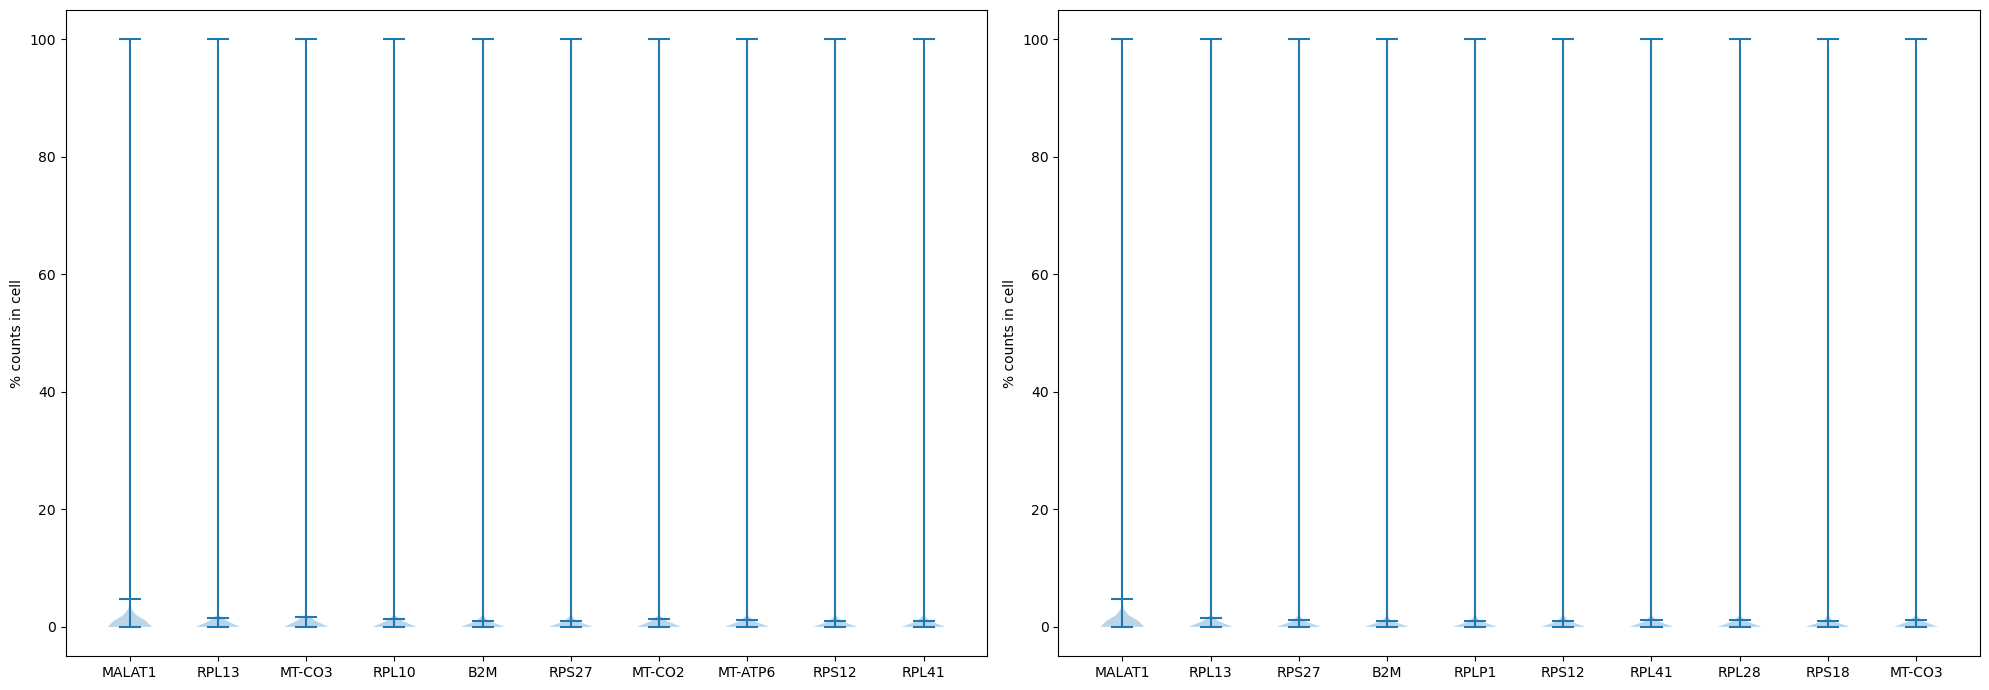

In [130]:
fig, axs = plt.subplots(1,2, figsize=(20,7))

for ax, data in zip(axs,sample_datasets):
    # Find top 10 genes by number of cells expressed
    top_genes = data.var.sort_values(by='n_cells',ascending=False).head(10).index
    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    # Get percent counts for each gene and add to metadata
    data.var['percent_counts'] = data.X.sum(axis=0).A1  / data.X.sum() * 100

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("% counts in cell")

plt.tight_layout()
plt.show()